<a href="https://colab.research.google.com/github/varaha-Maithreya/Person-Reidentification/blob/main/videoTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/varaha-Maithreya/Person-Reidentification.git

Cloning into 'Person-Reidentification'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 124 (delta 7), reused 114 (delta 6), pack-reused 5
Receiving objects: 100% (124/124), 345.83 KiB | 18.20 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
pip install timm scipy einops yacs opencv-python tensorboard pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 20.4 MB/s 
     |████████████████████████████████| 163 kB 54.3 MB/s 


In [3]:
!ls 

!pwd

Person-Reidentification  sample_data
/content


In [11]:
cd Person-Reidentification/


[Errno 2] No such file or directory: 'Person-Reidentification/'
/content/Person-Reidentification


In [15]:
import os
import torch, cv2
import numpy as np
from config import cfg
import argparse
from datasets import make_dataloader
from model import make_model
from processor import do_inference
from utils.logger import setup_logger
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from model.make_model import __num_of_layers
from model.make_model import build_transformer_local
from model.backbones.vit_pytorch import vit_base_patch16_224_PiT, vit_small_patch16_224_PiT, deit_small_patch16_224_PiT

In [20]:
cfg.merge_from_file("/content/Person-Reidentification/configs/iLIDS-VID/pit.yml")

cfg.merge_from_list(['TEST.VIS', "True"])
cfg.freeze()

In [21]:
output_dir = cfg.OUTPUT_DIR
if output_dir and not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [22]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [23]:
os.environ['CUDA_VISIBLE_DEVICES'] = cfg.MODEL.DEVICE_ID

In [24]:
os.environ['CUDA_VISIBLE_DEVICES'] 

'0'

In [25]:
epochs = cfg.SOLVER.MAX_EPOCHS
eval_period = cfg.SOLVER.EVAL_PERIOD
OUTPUT_DIR = cfg.TEST.WEIGHT


In [26]:
val_transforms = T.Compose([
   T.Resize(cfg.INPUT.SIZE_TEST, interpolation=3),
   T.ToTensor(),
   T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [27]:
__factory_T_type = {
    'vit_base_patch16_224_PiT': vit_base_patch16_224_PiT,
    'deit_base_patch16_224_PiT': vit_base_patch16_224_PiT,
    'vit_small_patch16_224_PiT': vit_small_patch16_224_PiT,
    'deit_small_patch16_224_PiT': deit_small_patch16_224_PiT
}

__num_of_layers = {
    '1x210' : 1,    # global
    '2x105' : 2,    # horizontal
    '3x70'  : 3,
    '5x42'  : 5,
    '6x35'  : 6,
    '7x10'  : 7,
    '105x2' : 2,    # vertical
    '70x3'  : 3,
    '42x5'  : 5,
    '35x6'  : 6,
    '10x7'  : 7,
    '6p'    : 6,    # patch
    '14p'   : 14,
    '15p'   : 15,
    'NULL'  : 0,
}

In [ ]:
model_path = 'transformer_120.pth'
#train_loader, val_loader, num_query, num_classes, camera_num, view_num = make_dataloader(cfg)
#model = make_model(cfg, num_class="1261", camera_num=camera_num, view_num=view_num)
#model.load_param(os.path.join(OUTPUT_DIR, model_path))

#model = build_transformer_local(num_class, camera_num, view_num, cfg, __factory_T_type,__num_of_layers, rearrange=cfg.MODEL.RE_ARRANGE)

model = build_transformer_local(1000, 0, 0, cfg, __factory_T_type,__num_of_layers, rearrange=cfg.MODEL.RE_ARRANGE)

model.to("cuda")
model.eval()
    


In [42]:
from torchvision.io import read_image
img = read_image('/content/pexels-lukas-rychvalsky-670786.jpg')

In [43]:
img.shape

torch.Size([3, 3214, 2146])

In [46]:
from PIL import Image
directory = '/content/pexels-lukas-rychvalsky-670786.jpg'
img = Image.open(directory)

In [47]:
val_transforms(img)

tensor([[[ 2.0777,  2.0777,  2.0777,  ...,  1.8722,  1.8550,  1.8208],
         [ 2.0777,  2.0777,  2.0777,  ...,  1.8550,  1.8550,  1.8550],
         [ 2.0777,  2.0777,  2.0777,  ...,  1.8550,  1.8550,  1.8550],
         ...,
         [ 1.5125,  1.6324,  1.4612,  ..., -1.1932, -1.1589, -1.1418],
         [ 1.6838,  1.4440,  0.2453,  ..., -0.9534, -1.1247, -1.1247],
         [ 1.4440,  1.1187,  0.4679,  ..., -1.0904, -1.1247, -1.1247]],

        [[ 2.2885,  2.2885,  2.2885,  ...,  2.1310,  2.1310,  2.1485],
         [ 2.2885,  2.2885,  2.2885,  ...,  2.1310,  2.1310,  2.1310],
         [ 2.2885,  2.2885,  2.2885,  ...,  2.1310,  2.1310,  2.1310],
         ...,
         [ 1.4482,  1.4307,  1.2206,  ..., -0.5826, -0.5476, -0.5476],
         [ 1.5882,  1.2906,  0.2052,  ..., -0.3550, -0.5476, -0.5301],
         [ 1.3606,  0.9930,  0.5203,  ..., -0.5126, -0.5301, -0.5301]],

        [[ 2.4483,  2.4483,  2.4483,  ...,  2.3437,  2.3437,  2.3437],
         [ 2.4483,  2.4483,  2.4483,  ...,  2

In [48]:
img = torch.stack([val_transforms(img)], 0).unsqueeze(0).to("cuda")

In [49]:
attns = model(img, cam_label=[0])

In [50]:
 attn_base, attn_head = attns
 att_base, att_head = torch.stack(attn_base).squeeze(1), torch.stack(attn_head).squeeze(1)


In [51]:
 # Average the attention weights across all heads.
att_base, att_head = torch.mean(att_base, dim=1), torch.mean(att_head, dim=1)


In [53]:
# To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
residual_att_base, redisual_att_head = \
    torch.eye(att_base.size(1)).to("cuda"), \
    torch.eye(att_head.size(1)).to("cuda")
aug_att_base, aug_att_head = \
    att_base + residual_att_base, \
    att_head + redisual_att_head
aug_att_base, aug_att_head = \
    aug_att_base / aug_att_base.sum(dim=-1).unsqueeze(-1), \
    aug_att_head / aug_att_head.sum(dim=-1).unsqueeze(-1)


In [55]:
 # Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_base.size()).to("cuda")
joint_attentions[0] = aug_att_base[0]

for n in range(1, aug_att_base.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_base[n], joint_attentions[n - 1])


In [64]:
im = Image.open(open('/content/pexels-lukas-rychvalsky-670786.jpg', 'rb'))

In [65]:
# Attention from the att_base output token to the input space.
v = joint_attentions[-1]
img_H, img_W = 21, 10
mask = v[0, 1:].reshape(img_H, img_W).detach().cpu().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")


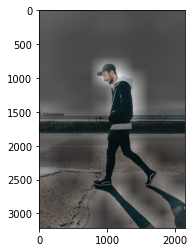

In [67]:
from matplotlib.backends.backend_pdf import PdfPages
plt.figure()
plt.imshow(result)
plt.show()

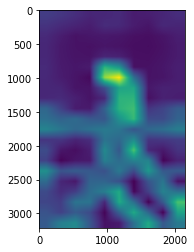

In [73]:
plt.figure()
plt.imshow(mask[:,:,0])
plt.show()

